In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Function Definitions
# -------------------------

def is_valid(pos, env_min=0, env_max=4):
    x, y = pos
    return env_min <= x <= env_max and env_min <= y <= env_max

def generate_grid_cells(n_cells=1000, arena_size=4, seed=None):
    if seed is not None:
        np.random.seed(seed)
    scales = np.random.uniform(0.02, 8, size=n_cells)
    phases = np.random.uniform(0, arena_size, size=(n_cells, 2))
    orientations = np.random.uniform(0, np.pi/3, size=n_cells)
    return scales, phases, orientations

def grid_activation(x, y, scales, phases, orientations):
    positions = np.array([x, y])
    activations = []
    angles = np.array([0, np.pi / 3, 2 * np.pi / 3])
    for scale, phase, orientation in zip(scales, phases, orientations):
        # Rotate and compute grating
        R = np.array([[np.cos(orientation), -np.sin(orientation)],
                      [np.sin(orientation),  np.cos(orientation)]])
        pos_rot = R @ (positions - phase)
        proj = pos_rot[0] * np.cos(angles) + pos_rot[1] * np.sin(angles)
        grating = np.sum(np.cos((4 * np.pi / (scale * np.sqrt(3))) * proj))
        activations.append((2/3) * grating)
    return np.array(activations)

def grid_activation_vectorized(X, Y, scales, phases, orientations):
    H, W = X.shape
    n_cells = len(scales)
    pos = np.stack([X.ravel(), Y.ravel()], axis=1)  # (H*W, 2)
    activations = np.zeros((H * W, n_cells))
    angles = np.array([0, np.pi / 3, 2 * np.pi / 3])

    for i in range(n_cells):
        scale = scales[i]
        phase = phases[i]
        orientation = orientations[i]
        c, s = np.cos(orientation), np.sin(orientation)
        R = np.array([[c, -s], [s, c]])
        rel_pos = pos - phase
        pos_rot = rel_pos @ R.T
        proj = np.outer(pos_rot[:, 0], np.cos(angles)) + np.outer(pos_rot[:, 1], np.sin(angles))
        grating = np.sum(np.cos((4 * np.pi / (scale * np.sqrt(3))) * proj), axis=1)
        activations[:, i] = (2/3) * grating

    return activations.reshape(H, W, n_cells)


# -------------------------
# Grid Cell Setup
# -------------------------

n_cells = 1000
env_min, env_max = 0, 4
scales, phases, orientations = generate_grid_cells(n_cells, env_max)

# -------------------------
# Plateau Events & Weights
# -------------------------

grid_res = 50

x_vals = np.linspace(env_min, env_max, grid_res)
y_vals = np.linspace(env_min, env_max, grid_res)
X, Y = np.meshgrid(x_vals, y_vals)

grid_embeddings = grid_activation_vectorized(X, Y, scales, phases, orientations)


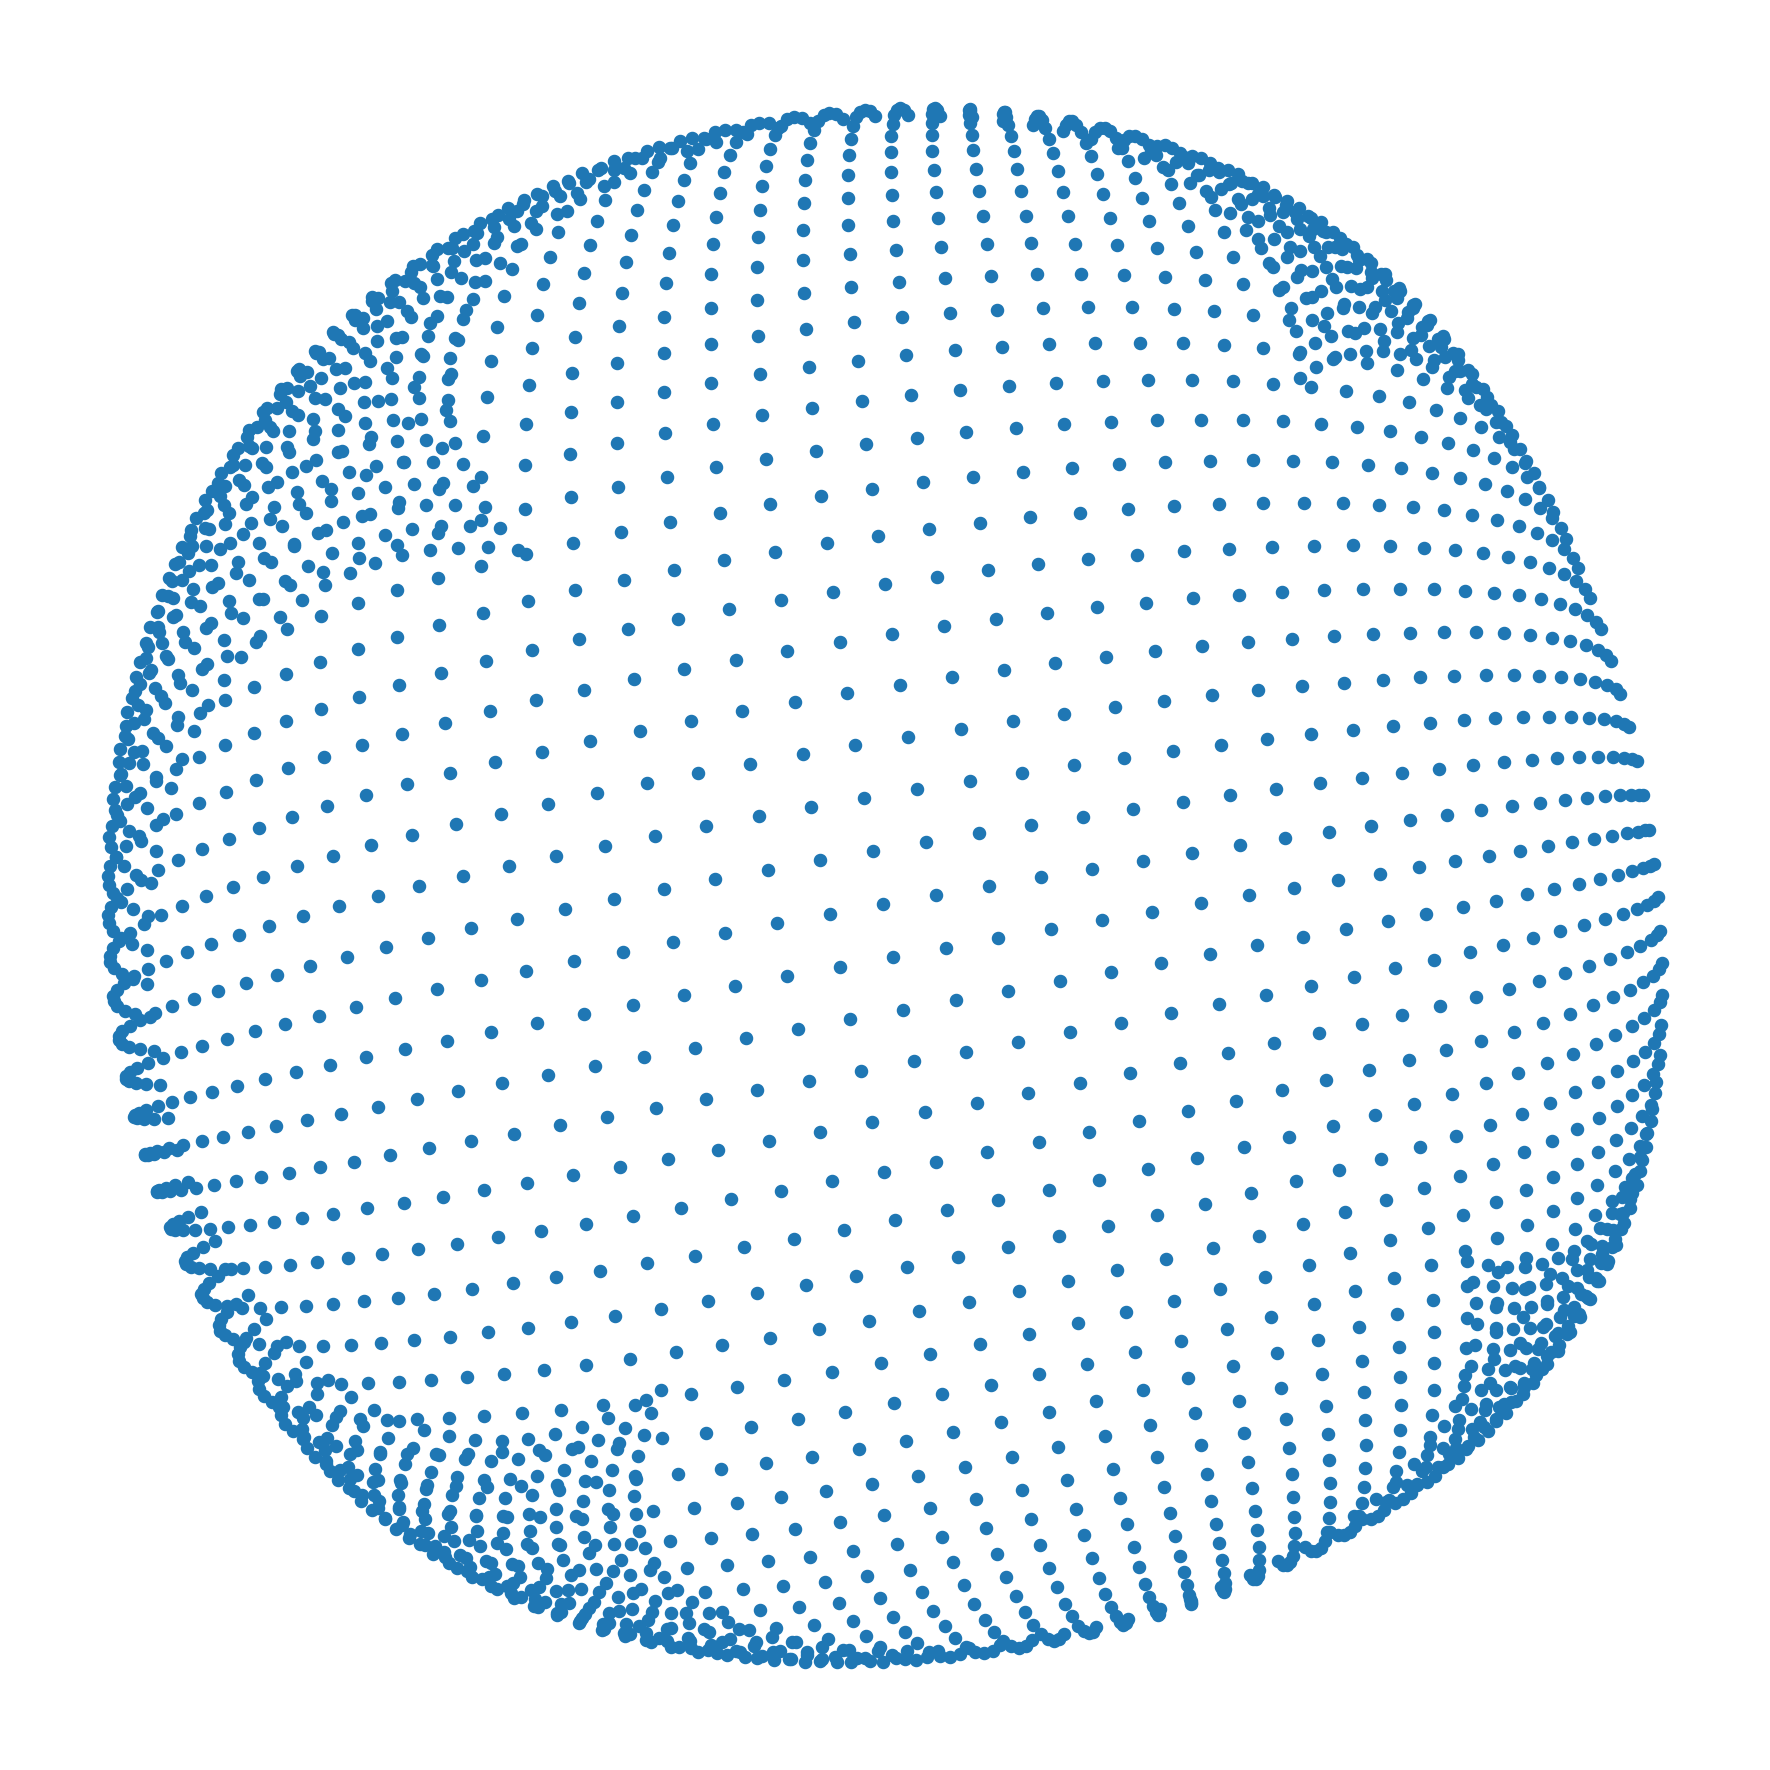

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


threshold = np.percentile(scales,85)
large_indices = np.where(scales >= threshold)[0]

# Extract embeddings for only those cells and flatten
H, W, _ = grid_embeddings.shape
emb_large = grid_embeddings[:, :, large_indices].reshape(H * W, len(large_indices))

# PCA on filtered embeddings
pca_large = PCA(n_components=2)
pc_large = pca_large.fit_transform(emb_large)

# Plot
plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(pc_large[:, 0], pc_large[:, 1], s=5)
# plt.title('PCA of Top 1%‑Scale Grid Cell Embeddings')
# plt.xlabel('PC1')
plt.axis('off')
# plt.ylabel('PC2')
plt.tight_layout()
plt.show()
